In [8]:
# Import any necessary libraries / modules
import os
import sys
import timeit

import pandas as pd # use this for analysing sampled portions of our data and comparison to Spark
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, when, split
from pyspark.sql.types import IntegerType, FloatType


In [2]:
# Create a path to the dataset and read into our Spark Session

DATA_PATH = os.path.join("..", "datasets", "tracks_features.csv")
print(DATA_PATH)

spark = SparkSession.builder.appName("SongRecommendation").getOrCreate()

'''
First exercise is to just compare execution time between Pandas and PySpark...

There is already a meaningful difference due to dataset size of 1.2million rows, but remember 
that Spark is being run locally (single cluster) and our dataset is still relatively small 
(i.e. 350mb vs hundreds of gigs or tb in real-world applications)
'''
# Function to read with PySpark
def read_with_spark():
    df = spark.read.csv(DATA_PATH)

# Function to read with Pandas
def read_with_pandas():
    df = pd.read_csv(DATA_PATH)

# Measure execution time
spark_time = timeit.timeit(read_with_spark, number=1)  # Run once
pandas_time = timeit.timeit(read_with_pandas, number=1)  # Run once

# Print results
print(f"Time taken with PySpark: {spark_time:.4f} seconds")
print(f"Time taken with Pandas: {pandas_time:.4f} seconds")

../datasets/tracks_features.csv


your 131072x1 screen size is bogus. expect trouble
25/02/19 15:11:40 WARN Utils: Your hostname, DESKTOP-2SKV9RF resolves to a loopback address: 127.0.1.1; using 172.20.62.62 instead (on interface eth0)
25/02/19 15:11:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/19 15:11:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Time taken with PySpark: 6.4351 seconds
Time taken with Pandas: 7.4651 seconds


In [3]:
# Let's ready our data in memory and get ready for data processing
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)
# Show the first 5 tracks
df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------------------+---+-------------------+----+-----------+------------+----------------+-------------------+-------+-----------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|            energy|key|           loudness|mode|speechiness|acousticness|instrumentalness|           liveness|valence|            tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------------------+---+-------------------+----+-----------+------------+----------------+-------------------+----

In [4]:
# Collect general information on original dataset
nrows, ncols = df.count(), len(df.columns)
print(f"Data contains {nrows} rows and {ncols} cols")
df.printSchema() # <-- uh-oh, all data types are string...


Data contains 1204025 rows and 24 cols
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: string (nullable = true)
 |-- disc_number: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- year: string (nullable = true)
 |-- release_date: string (nulla

In [5]:
# We were unable to infer the schema when reading the CSV with PySpark
# Let's cast these columns to their correct types

# Cast explicit to an IntType
bool_col = "explicit"
df = df.withColumn(bool_col, when(col(bool_col) == "True", 1)
                                    .when(col(bool_col) == "False", 0)
                                    .otherwise(0)) 

# TODO: we'll need to fix splitting these columns later
# Convert string representation of list into array of strings 
# df = df.withColumn("artists", split(col("artists"), ",\s*")) \
#        .withColumn("artist_ids", split(col("artist_ids"), ",\s*"))

# Cast the other numerical columns
int_cols = ["track_number", "disc_number", "key", "mode", "duration_ms", "year"]
float_cols = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

for col_name in int_cols:
    df = df.withColumn(col_name, col(col_name).cast(IntegerType()))

for col_name in float_cols:
    df = df.withColumn(col_name, col(col_name).cast(FloatType()))

df.printSchema()
df.show(5)



root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: integer (nullable = true)
 |-- disc_number: integer (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- release_date: string (nullable = true)

+--------------------+------

In [6]:
'''
Drop rows with missing values and drop duplicate rows w/ matching artist_ids and case-insensitive names

NOTE: .count() requires computation across whole cluster, so probably inefficient in real 
world to query often 
'''

df = (df
      .dropna()
      .withColumn("name_lower", lower(col("name")))
      .dropDuplicates(["name_lower", "artist_ids"])
      .drop("name_lower")
)

nrows, ncols = df.count(), len(df.columns)            
print(f"Data contains {nrows} rows and {ncols} cols")

Data contains 1129285 rows and 24 cols


In [7]:
# Let's do some analysis on just the numerical columns

df_numerical = df.select(int_cols + float_cols)
numer_rows, numer_cols = df_numerical.count(), len(df_numerical.columns)
print(f"Data contains {numer_rows} rows and {numer_cols} cols")

df_numerical.summary().show()


Data contains 1129285 rows and 16 cols


25/02/19 15:12:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/02/19 15:12:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/19 15:12:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/19 15:12:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/19 15:12:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------+-----------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|     track_number|        disc_number|               key|               mode|       duration_ms|              year|       danceability|             energy|           loudness|        speechiness|       acousticness|   instrumentalness|           liveness|            valence|             tempo|    time_signature|
+-------+-----------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|  count|          1129285|    

25/02/19 16:05:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/19 16:05:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/19 16:05:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/02/19 16:05:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


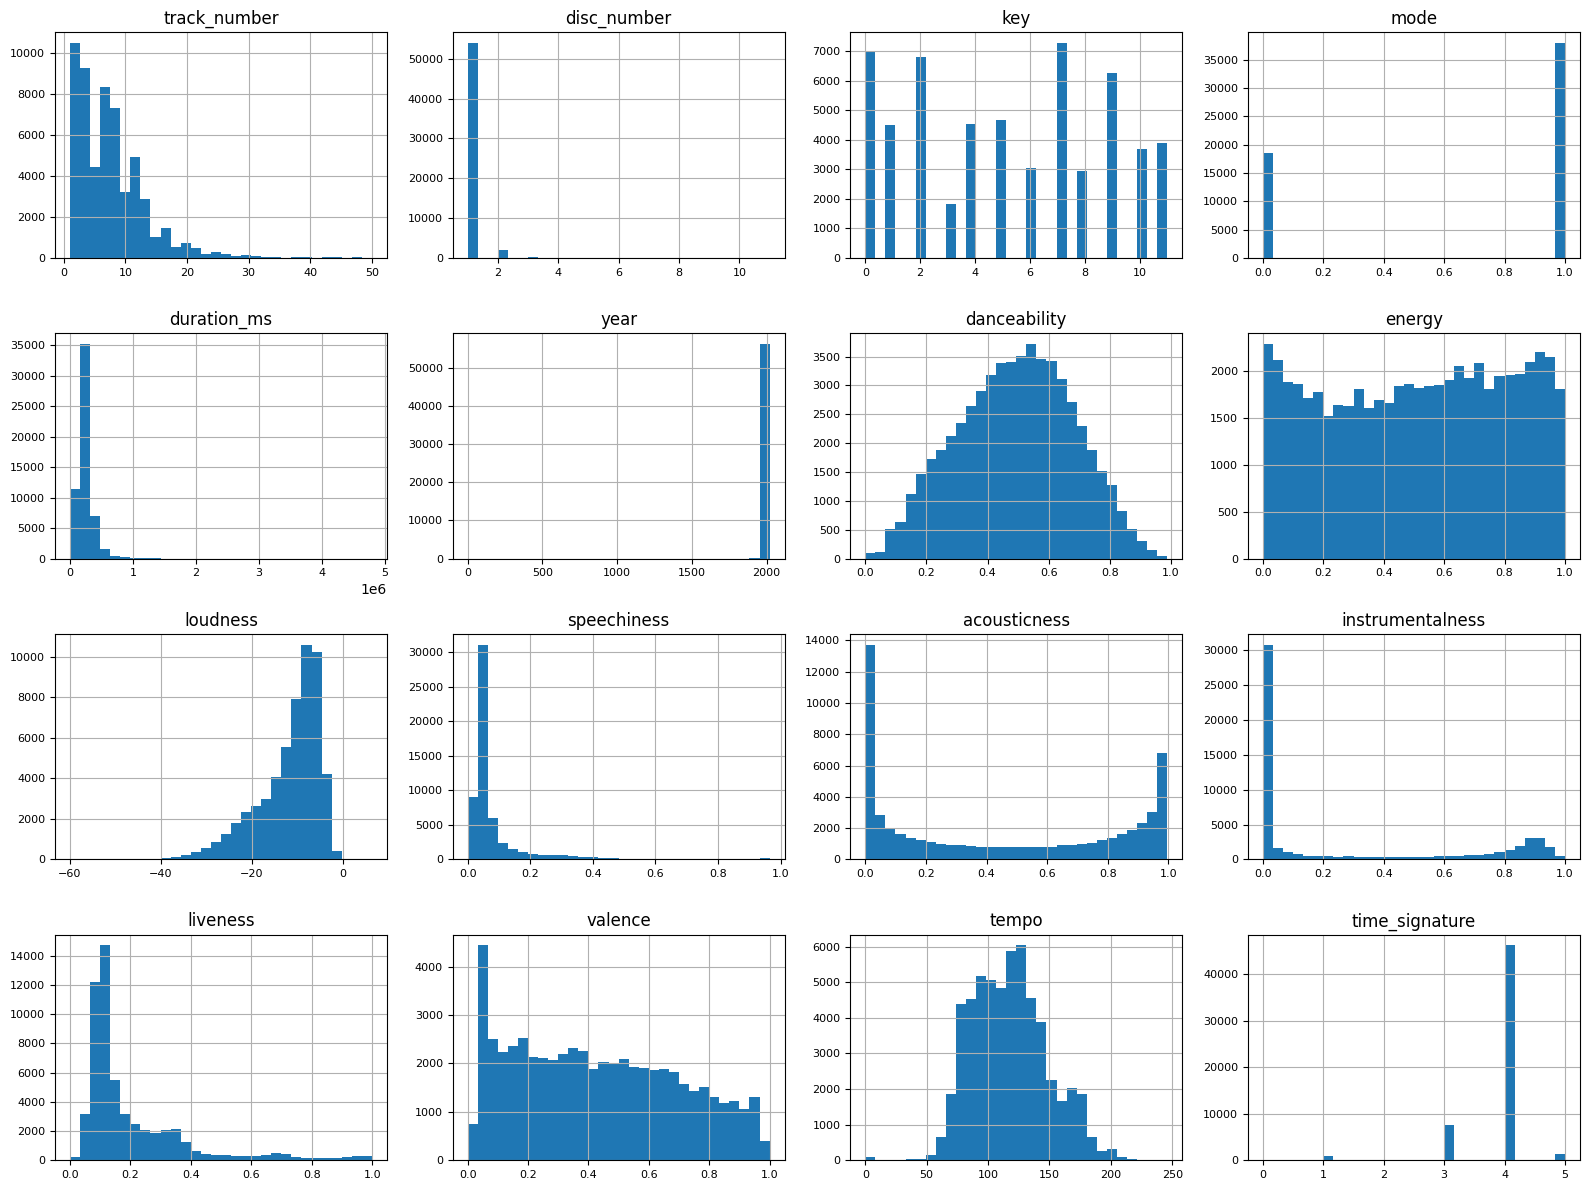

In [10]:
# Let's sample about 5% of this data and convert to a panda's dataframe for some visual analysis
df_sampled = df_numerical.sample(fraction=0.05, seed=42).toPandas()

# View the distributions of these features
df_sampled.hist(figsize=(12, 9), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

**General Observations**

Columns like `liveness`, `speechiness` experience right-skewed distirbutions. 
`danceability`, `tempo`, and `valence` appear normally distributed.

Looking at this data, it features like `time_signature`, `year`, `key`, and `disc_number` are more categorical in nature and would probably not help in building our recommendation system, so we will drop these features in our pre-processing stage. As for year, we have another qualitative feature called `release_date` not displayed above which can be used instead if we need to factor in recent selections into our recommendation system. 

I'm assuming `track_number` refers to the position of a song within an album and this is also irrelevant for our content based matching system, so we can drop this as well.